<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: Outlier Detection for MIRI MRS

<span style="color:red"> **Instruments Affected**</span>: MIRI


Tested on MIRI Simulated data



#### Author: Isha Nayak

This notebook checks the outlier detection step of the pipeline during calwebb_spec3 for Channel 1 long wavelengths.

First this notebook checks ten different locations in the detector and confirm these pixels in the detector fall in the range of the Channel 1 long wavelength range (6.42 - 7.51 microns). These outliers range from 3000 to 30000 in value to make sure a range of outlier values can be detected in the pipeline. After the outliers are injected in the detector frame, a file is saved.

We then run the cube build step (without outlier detection) and name this file with suffix 'before' to denote the effect before outlier detection step. Then we run outlier detection and cube build steps of calwebb_spec3. The output from the second run ends in suffix 'after' since this is after the outlier detection step has been run.

The image and the mask in the detector frame is shown to confirm proper (x,y) coordinates have been chosen. Then the cube slice of the expected outlier is shown with and without the outlier detector step for each of the ten outliers inserted. 

Outliers at varying flux levels get detected and removed with the pipeline. The flux of the central source different when using outlier detection in comparison to when not using outlier detection. This difference is as high as 35%. We set this as the criteria for passing.

In [1]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


In [2]:
# Basic system utilities for interacting with files
import glob, sys, os, time

# Astropy utilities for opening FITS and ASCII files
from astropy.io import fits
from astropy.io import ascii

# Astropy utilities for making plots
from astropy.visualization import (LinearStretch, LogStretch, ImageNormalize, ZScaleInterval)

# Numpy for doing calculations
import numpy as np

# Matplotlib for making plots
import matplotlib.pyplot as plt
from matplotlib import rc

# JWST pipelines
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

# Individual JWST pipeline steps
from jwst.assign_wcs import AssignWcsStep
from jwst.background import BackgroundStep
from jwst.flatfield import FlatFieldStep
from jwst.srctype import SourceTypeStep
from jwst.straylight import StraylightStep
from jwst.fringe import FringeStep
from jwst.photom import PhotomStep
from jwst.cube_build import CubeBuildStep
from jwst.extract_1d import Extract1dStep
from jwst.cube_skymatch import CubeSkyMatchStep
from jwst.master_background import MasterBackgroundStep
from jwst.outlier_detection import OutlierDetectionStep
from jwst.extract_1d import Extract1dStep

# JWST pipeline utilities
from jwst.datamodels import dqflags
from jwst import datamodels
from jwst.associations import asn_from_list as afl
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
import stcal

# MIRIcoord for detector to pixel conversion
import miricoord
import miricoord.mrs.mrs_tools as mt

# Box download imports 
from astropy.utils.data import download_file
from pathlib import Path
from shutil import move
from os.path import splitext

### Create a temporary location for the data

In [3]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

Running in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpv8buccnn


In [4]:
# Check JWST version
import jwst
print(jwst.__version__ )

1.4.3


In [5]:
# Check stcal version
print(stcal.__version__ )

0.6.1


### Read in data from Box

In [6]:
# Function for Box files
def get_box_files(file_list):
    for box_url,file_name in file_list:
        if 'https' not in box_url:
            box_url = 'https://stsci.box.com/shared/static/' + box_url
        downloaded_file = download_file(box_url)
        if Path(file_name).suffix == '':
            ext = splitext(box_url)[1]
            file_name += ext
        move(downloaded_file, file_name)

In [7]:
# Get the files from Box
file_urls = ['https://stsci.box.com/shared/static/7va325g09uesfh9wb569sedcefll4cv3.fits', 
                  'https://stsci.box.com/shared/static/jsyf3k5frn4w3zzw7hrqbbe92iszgye5.fits',   
                  'https://stsci.box.com/shared/static/6tlbhwco7qz98qvnew6x0797cugp68re.fits',    
                  'https://stsci.box.com/shared/static/w3oj50ei9py7i9e9jmi3d2oyr40127us.fits '] 
file_names = ['det_image_seq1_MIRIFUSHORT_12LONGexp1_cal.fits',              
               'det_image_seq2_MIRIFUSHORT_12LONGexp1_cal.fits',             
               'det_image_seq3_MIRIFUSHORT_12LONGexp1_cal.fits',            
               'det_image_seq4_MIRIFUSHORT_12LONGexp1_cal.fits']  
box_download_list = [(url,name) for url,name in zip(file_urls,file_names)]  
get_box_files(box_download_list)

### Start data processing

In [8]:
# Look for our _rate.fits files produced by the Detector1 pipeline
sstring='det*cal.fits'
calfiles=sorted(glob.glob(sstring))
print(calfiles)

['det_image_seq1_MIRIFUSHORT_12LONGexp1_cal.fits', 'det_image_seq2_MIRIFUSHORT_12LONGexp1_cal.fits', 'det_image_seq3_MIRIFUSHORT_12LONGexp1_cal.fits', 'det_image_seq4_MIRIFUSHORT_12LONGexp1_cal.fits']


In [9]:
# Check detector array to pixel array values for ten inserted outliers and check the exepected wavelength
lambda_wav=[0.0]*9
n=0
skip=100
for x in range(0, 10):
    count=0
    for i in range(355, 358):
        for j in range(20+(n*skip), 23+(n*skip)):
            values=mt.xytoabl([i],[j],'1C')
            lambda_wav[count]=values['lam']
            count=count+1
    print(n+1)
    print(min(lambda_wav))    
    print(max(lambda_wav))
    n=n+1

1
[6.42021683]
[6.42293412]


2
[6.54556429]
[6.54822304]


3
[6.66816384]
[6.67076253]


4
[6.78801549]
[6.79055257]


5
[6.90511925]
[6.90759317]


6
[7.01947511]
[7.02188433]


7
[7.13108307]
[7.13342604]


8
[7.23994313]
[7.24221831]


9
[7.34605529]
[7.34826114]


10
[7.44941956]
[7.45155452]


In [10]:
# Hack the file
hdu=fits.open(calfiles[0])
data=hdu['SCI'].data

# Insert the ten outliers varying from 3000 to 30000
n=0
skip=100
for x in range(0, 10):
    for i in range(355,358):
        for j in range(20+(n*skip), 23+(n*skip)):
            data[j,i]=3000*(n+1)
    n=n+1
hdu['SCI'].data=data

# Overwrite the file
hdu.writeto(str.replace(calfiles[0],'cal','od_test'),overwrite=True)
hdu.close()

In [11]:
# Define a useful function to write out a Lvl3 association file from an input list
def writel3asn(files,asnfile,prodname,**kwargs):
    asn = afl.asn_from_list(files,rule=DMS_Level3_Base,product_name=prodname)
    if ('bg' in kwargs):
        for bgfile in kwargs['bg']:
            asn['products'][0]['members'].append({'expname': bgfile, 'exptype':'background'})
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

In [12]:
# Create an association file
testfiles=calfiles.copy()
testfiles[0]=str.replace(calfiles[0],'cal','od_test')
writel3asn(testfiles,'od.json','od')

In [13]:
# Run it through cube building calling the result 'od_before'
cb=CubeBuildStep()
cb.call('od.json',channel='1',save_results=True,output_file='od_before')

2022-03-24 12:12:49,563 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.


2022-03-24 12:12:56,129 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.


2022-03-24 12:12:56,587 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep running with args ('od.json',).


2022-03-24 12:12:56,590 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpv8buccnn/od_before', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': '1', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'band', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': False}


2022-03-24 12:12:56,590 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step


2022-03-24 12:12:56,591 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud


2022-03-24 12:12:56,591 - stpipe.CubeBuildStep - INFO - Coordinate system to use: skyalign


2022-03-24 12:12:56,591 - stpipe.CubeBuildStep - INFO - Weighting method for point cloud: emsm


2022-03-24 12:12:56,592 - stpipe.CubeBuildStep - INFO - Power weighting distance: 2.0


2022-03-24 12:13:02,325 - stpipe.CubeBuildStep - INFO - The desired cubes cover the MIRI Channels: ['1']


2022-03-24 12:13:02,327 - stpipe.CubeBuildStep - INFO - The desired cubes cover the MIRI subchannels: ['long']


2022-03-24 12:13:02,327 - stpipe.CubeBuildStep - INFO - Reading cube parameter file /grp/crds/cache/references/jwst/jwst_miri_cubepar_0006.fits


2022-03-24 12:13:03,220 - stpipe.CubeBuildStep - INFO - The user has selected the type of IFU cube to make


2022-03-24 12:13:03,221 - stpipe.CubeBuildStep - INFO - Number of IFU cubes produced by this run = 1


2022-03-24 12:13:03,227 - stpipe.CubeBuildStep - INFO - Mapping all pixels to output to determine IFU foot print


2022-03-24 12:13:03,585 - stpipe.CubeBuildStep - INFO - Mapping all pixels to output to determine IFU foot print


2022-03-24 12:13:03,904 - stpipe.CubeBuildStep - INFO - Mapping all pixels to output to determine IFU foot print


2022-03-24 12:13:04,215 - stpipe.CubeBuildStep - INFO - Mapping all pixels to output to determine IFU foot print


2022-03-24 12:13:04,529 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2022-03-24 12:13:04,530 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-03-24 12:13:04,530 - stpipe.CubeBuildStep - INFO - Axis 1    35  18.00   0.00002193   0.13000000  -2.27499992   2.27499992


2022-03-24 12:13:04,531 - stpipe.CubeBuildStep - INFO - Axis 2    35  18.00   0.00003324   0.13000000  -2.27499992   2.27499992


2022-03-24 12:13:04,531 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-03-24 12:13:04,531 - stpipe.CubeBuildStep - INFO - Axis 3  1091   1.00   6.42050008   0.00100000   6.42000008   7.51100013


2022-03-24 12:13:04,532 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 1, long


2022-03-24 12:13:04,532 - stpipe.CubeBuildStep - INFO - Output Name: od_before_ch1-long_s3d.fits


2022-03-24 12:13:04,953 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2022-03-24 12:13:04,954 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2022-03-24 12:13:06,946 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2022-03-24 12:13:06,947 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2022-03-24 12:13:08,921 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2022-03-24 12:13:08,923 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2022-03-24 12:13:10,946 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2022-03-24 12:13:10,947 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2022-03-24 12:13:12,581 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2022-03-24 12:13:12,582 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2022-03-24 12:13:14,618 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  0.000635814 -0.000580646 0.000635814 0.000647132 359.999408037 0.000647132 359.999408037 -0.000580646


2022-03-24 12:13:15,054 - stpipe.CubeBuildStep - INFO - Saved model in od_before_ch1-long_s3d.fits


2022-03-24 12:13:15,055 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep done


<ModelContainer>

In [14]:
# Run this association through the Spec3 pipeline with just outlier detection and cube build
spec3=Spec3Pipeline()
spec3.save_results = True
spec3.master_background.skip = True
spec3.mrs_imatch.skip = True
spec3.outlier_detection.save_intermediate_results = True
spec3.outlier_detection.scale = '2.0 2.0'
spec3.cube_build.channel='1'
spec3.cube_build.output_file='od_after'
spec3('od.json')

2022-03-24 12:13:15,072 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.


2022-03-24 12:13:15,073 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2022-03-24 12:13:15,074 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.


2022-03-24 12:13:15,076 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.


2022-03-24 12:13:15,077 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2022-03-24 12:13:15,078 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-03-24 12:13:15,080 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-03-24 12:13:15,081 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-03-24 12:13:15,083 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance created.


2022-03-24 12:13:15,456 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline running with args ('od.json',).


2022-03-24 12:13:15,464 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'master_background': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'user_background': None, 'save_background': False, 'force_subtract': False}, 'mrs_imatch': {'pre_ho

2022-03-24 12:13:16,332 - stpipe.Spec3Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFUSHORT_12LONGexp1_od_test.fits' reftypes = ['apcorr', 'cubepar', 'drizpars', 'extract1d', 'speckernel', 'specprofile', 'spectrace', 'wavemap']


2022-03-24 12:13:16,337 - stpipe.Spec3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf'.


2022-03-24 12:13:16,338 - stpipe.Spec3Pipeline - INFO - Prefetch for CUBEPAR reference file is '/grp/crds/cache/references/jwst/jwst_miri_cubepar_0006.fits'.


2022-03-24 12:13:16,340 - stpipe.Spec3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-03-24 12:13:16,341 - stpipe.Spec3Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf'.


2022-03-24 12:13:16,342 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2022-03-24 12:13:16,343 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2022-03-24 12:13:16,343 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECTRACE reference file is 'N/A'.


2022-03-24 12:13:16,343 - stpipe.Spec3Pipeline - INFO - Prefetch for WAVEMAP reference file is 'N/A'.


2022-03-24 12:13:16,344 - stpipe.Spec3Pipeline - INFO - Starting calwebb_spec3 ...


2022-03-24 12:13:21,377 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step mrs_imatch running with args (<ModelContainer>,).


2022-03-24 12:13:21,378 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step mrs_imatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'mrs_imatch', 'search_output_file': True, 'input_dir': '', 'bkg_degree': 1, 'subtract': False}


2022-03-24 12:13:21,379 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step skipped.


2022-03-24 12:13:21,385 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step mrs_imatch done


2022-03-24 12:13:21,641 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2022-03-24 12:13:21,643 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '2.0 2.0', 'backg': 0.0, 'save_intermediate_results': True, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2022-03-24 12:13:21,650 - stpipe.Spec3Pipeline.outlier_detection - INFO - Performing outlier detection on 4 inputs


2022-03-24 12:13:26,423 - stpipe.Spec3Pipeline.outlier_detection - INFO - Performing IFU outlier_detection for exptype MIR_MRS


2022-03-24 12:13:26,425 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.


2022-03-24 12:13:26,425 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step


2022-03-24 12:13:26,426 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud


2022-03-24 12:13:26,426 - stpipe.CubeBuildStep - INFO - Coordinate system to use: skyalign


2022-03-24 12:13:26,426 - stpipe.CubeBuildStep - INFO - Weighting method for point cloud: emsm


2022-03-24 12:13:26,426 - stpipe.CubeBuildStep - INFO - Power weighting distance: 2.0


2022-03-24 12:13:26,427 - stpipe.CubeBuildStep - INFO - Cube Type: Single cubes


2022-03-24 12:13:26,476 - stpipe.Spec3Pipeline.outlier_detection - INFO - The desired cubes cover the MIRI Channels: ['1']


2022-03-24 12:13:26,476 - stpipe.Spec3Pipeline.outlier_detection - INFO - The desired cubes cover the MIRI subchannels: ['long']


2022-03-24 12:13:26,477 - stpipe.Spec3Pipeline.outlier_detection - INFO - Reading cube parameter file /grp/crds/cache/references/jwst/jwst_miri_cubepar_0006.fits


2022-03-24 12:13:27,349 - stpipe.Spec3Pipeline.outlier_detection - INFO - Single = true, creating a set of single exposures mapped to output IFUCube coordinate system


2022-03-24 12:13:27,354 - stpipe.Spec3Pipeline.outlier_detection - INFO - Mapping all pixels to output to determine IFU foot print


2022-03-24 12:13:27,685 - stpipe.Spec3Pipeline.outlier_detection - INFO - Mapping all pixels to output to determine IFU foot print


2022-03-24 12:13:28,015 - stpipe.Spec3Pipeline.outlier_detection - INFO - Mapping all pixels to output to determine IFU foot print


2022-03-24 12:13:28,350 - stpipe.Spec3Pipeline.outlier_detection - INFO - Mapping all pixels to output to determine IFU foot print


2022-03-24 12:13:28,679 - stpipe.Spec3Pipeline.outlier_detection - INFO - Cube Geometry:


2022-03-24 12:13:28,680 - stpipe.Spec3Pipeline.outlier_detection - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-03-24 12:13:28,680 - stpipe.Spec3Pipeline.outlier_detection - INFO - Axis 1    35  18.00   0.00002193   0.13000000  -2.27499992   2.27499992


2022-03-24 12:13:28,680 - stpipe.Spec3Pipeline.outlier_detection - INFO - Axis 2    35  18.00   0.00003324   0.13000000  -2.27499992   2.27499992


2022-03-24 12:13:28,681 - stpipe.Spec3Pipeline.outlier_detection - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-03-24 12:13:28,681 - stpipe.Spec3Pipeline.outlier_detection - INFO - Axis 3  1091   1.00   6.42050008   0.00100000   6.42000008   7.51100013


2022-03-24 12:13:28,682 - stpipe.Spec3Pipeline.outlier_detection - INFO - Cube covers channel, subchannel: 1, long


2022-03-24 12:13:29,085 - stpipe.Spec3Pipeline.outlier_detection - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2022-03-24 12:13:29,086 - stpipe.Spec3Pipeline.outlier_detection - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2022-03-24 12:13:32,760 - stpipe.Spec3Pipeline.outlier_detection - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2022-03-24 12:13:32,761 - stpipe.Spec3Pipeline.outlier_detection - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2022-03-24 12:13:35,947 - stpipe.Spec3Pipeline.outlier_detection - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2022-03-24 12:13:35,948 - stpipe.Spec3Pipeline.outlier_detection - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2022-03-24 12:13:39,648 - stpipe.Spec3Pipeline.outlier_detection - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2022-03-24 12:13:39,649 - stpipe.Spec3Pipeline.outlier_detection - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2022-03-24 12:13:42,448 - stpipe.CubeBuildStep - INFO - Number of Single IFUCube models returned 4 


2022-03-24 12:13:42,451 - stpipe.Spec3Pipeline.outlier_detection - INFO - Update S_REGION to POLYGON ICRS  0.000635814 -0.000580646 0.000635814 0.000647132 359.999408037 0.000647132 359.999408037 -0.000580646


2022-03-24 12:13:42,454 - stpipe.Spec3Pipeline.outlier_detection - INFO - Update S_REGION to POLYGON ICRS  0.000635814 -0.000580646 0.000635814 0.000647132 359.999408037 0.000647132 359.999408037 -0.000580646


2022-03-24 12:13:42,457 - stpipe.Spec3Pipeline.outlier_detection - INFO - Update S_REGION to POLYGON ICRS  0.000635814 -0.000580646 0.000635814 0.000647132 359.999408037 0.000647132 359.999408037 -0.000580646


2022-03-24 12:13:42,460 - stpipe.Spec3Pipeline.outlier_detection - INFO - Update S_REGION to POLYGON ICRS  0.000635814 -0.000580646 0.000635814 0.000647132 359.999408037 0.000647132 359.999408037 -0.000580646


2022-03-24 12:13:42,463 - stpipe.Spec3Pipeline.outlier_detection - INFO - Writing out (single) IFU cube det_image_seq1_MIRIFUSHORT_12LONGexp1_od_test_ch1-long_single_a3001_outlier_s3d.fits


2022-03-24 12:13:42,890 - stpipe.Spec3Pipeline.outlier_detection - INFO - Writing out (single) IFU cube det_image_seq2_MIRIFUSHORT_12LONGexp1_cal_ch1-long_single_a3001_outlier_s3d.fits


2022-03-24 12:13:43,323 - stpipe.Spec3Pipeline.outlier_detection - INFO - Writing out (single) IFU cube det_image_seq3_MIRIFUSHORT_12LONGexp1_cal_ch1-long_single_a3001_outlier_s3d.fits


2022-03-24 12:13:43,747 - stpipe.Spec3Pipeline.outlier_detection - INFO - Writing out (single) IFU cube det_image_seq4_MIRIFUSHORT_12LONGexp1_cal_ch1-long_single_a3001_outlier_s3d.fits


2022-03-24 12:13:44,926 - stpipe.Spec3Pipeline.outlier_detection - INFO - Writing out MEDIAN image to: od_a3001_ch1_long_median_s3d.fits


2022-03-24 12:13:45,617 - stpipe.Spec3Pipeline.outlier_detection - INFO - Information on Blotting


2022-03-24 12:13:45,618 - stpipe.Spec3Pipeline.outlier_detection - INFO - Working with instrument MIRI


2022-03-24 12:13:45,619 - stpipe.Spec3Pipeline.outlier_detection - INFO - Shape of sky cube 35.000000 35.000000 1091.000000


2022-03-24 12:13:45,619 - stpipe.Spec3Pipeline.outlier_detection - INFO - Channel 1


2022-03-24 12:13:45,620 - stpipe.Spec3Pipeline.outlier_detection - INFO - Sub-channel long


2022-03-24 12:13:47,260 - stpipe.Spec3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:592: RuntimeWarning: invalid value encountered in add
  result = [np.empty(inputs[0].shape) +



2022-03-24 12:13:47,504 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting back to det_image_seq1_MIRIFUSHORT_12LONGexp1_od_test.fits


2022-03-24 12:13:51,593 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting back to det_image_seq2_MIRIFUSHORT_12LONGexp1_cal.fits


2022-03-24 12:13:55,208 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting back to det_image_seq3_MIRIFUSHORT_12LONGexp1_cal.fits


2022-03-24 12:13:58,785 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting back to det_image_seq4_MIRIFUSHORT_12LONGexp1_cal.fits


2022-03-24 12:14:01,899 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.


2022-03-24 12:14:01,900 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step


2022-03-24 12:14:01,901 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud


2022-03-24 12:14:01,901 - stpipe.CubeBuildStep - INFO - Coordinate system to use: skyalign


2022-03-24 12:14:01,901 - stpipe.CubeBuildStep - INFO - Weighting method for point cloud: emsm


2022-03-24 12:14:01,901 - stpipe.CubeBuildStep - INFO - Power weighting distance: 2.0


2022-03-24 12:14:01,902 - stpipe.CubeBuildStep - INFO - Cube Type: Single cubes


2022-03-24 12:14:01,956 - stpipe.Spec3Pipeline.outlier_detection - INFO - The desired cubes cover the MIRI Channels: ['2']


2022-03-24 12:14:01,956 - stpipe.Spec3Pipeline.outlier_detection - INFO - The desired cubes cover the MIRI subchannels: ['long']


2022-03-24 12:14:01,957 - stpipe.Spec3Pipeline.outlier_detection - INFO - Reading cube parameter file /grp/crds/cache/references/jwst/jwst_miri_cubepar_0006.fits


2022-03-24 12:14:02,835 - stpipe.Spec3Pipeline.outlier_detection - INFO - Single = true, creating a set of single exposures mapped to output IFUCube coordinate system


2022-03-24 12:14:02,843 - stpipe.Spec3Pipeline.outlier_detection - INFO - Cube Geometry:


2022-03-24 12:14:02,843 - stpipe.Spec3Pipeline.outlier_detection - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-03-24 12:14:02,843 - stpipe.Spec3Pipeline.outlier_detection - INFO - Axis 1    33  17.00   0.00001735   0.17000000  -2.80500003   2.80500003


2022-03-24 12:14:02,844 - stpipe.Spec3Pipeline.outlier_detection - INFO - Axis 2    35  18.00  -0.00012632   0.17000000  -2.97500003   2.97500003


2022-03-24 12:14:02,844 - stpipe.Spec3Pipeline.outlier_detection - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-03-24 12:14:02,844 - stpipe.Spec3Pipeline.outlier_detection - INFO - Axis 3   855   1.00  10.03099973   0.00200000  10.02999973  11.73999981


2022-03-24 12:14:02,845 - stpipe.Spec3Pipeline.outlier_detection - INFO - Cube covers channel, subchannel: 2, long


2022-03-24 12:14:03,178 - stpipe.Spec3Pipeline.outlier_detection - INFO - # of detector pixels not mapped to output plane: 7871 with wavelength below 10.025999733130448


2022-03-24 12:14:03,179 - stpipe.Spec3Pipeline.outlier_detection - INFO - # of detector pixels not mapped to output plane: 11714 with wavelength above 11.743999814032577


2022-03-24 12:14:06,261 - stpipe.Spec3Pipeline.outlier_detection - INFO - # of detector pixels not mapped to output plane: 7871 with wavelength below 10.025999733130448


2022-03-24 12:14:06,262 - stpipe.Spec3Pipeline.outlier_detection - INFO - # of detector pixels not mapped to output plane: 11714 with wavelength above 11.743999814032577


2022-03-24 12:14:10,084 - stpipe.Spec3Pipeline.outlier_detection - INFO - # of detector pixels not mapped to output plane: 7871 with wavelength below 10.025999733130448


2022-03-24 12:14:10,085 - stpipe.Spec3Pipeline.outlier_detection - INFO - # of detector pixels not mapped to output plane: 11714 with wavelength above 11.743999814032577


2022-03-24 12:14:13,163 - stpipe.Spec3Pipeline.outlier_detection - INFO - # of detector pixels not mapped to output plane: 7871 with wavelength below 10.025999733130448


2022-03-24 12:14:13,164 - stpipe.Spec3Pipeline.outlier_detection - INFO - # of detector pixels not mapped to output plane: 11714 with wavelength above 11.743999814032577


2022-03-24 12:14:15,976 - stpipe.CubeBuildStep - INFO - Number of Single IFUCube models returned 4 


2022-03-24 12:14:15,979 - stpipe.Spec3Pipeline.outlier_detection - INFO - Update S_REGION to POLYGON ICRS  0.000772903 -0.000929096 0.000772903 0.000676459 359.999261791 0.000676459 359.999261791 -0.000929096


2022-03-24 12:14:15,982 - stpipe.Spec3Pipeline.outlier_detection - INFO - Update S_REGION to POLYGON ICRS  0.000772903 -0.000929096 0.000772903 0.000676459 359.999261791 0.000676459 359.999261791 -0.000929096


2022-03-24 12:14:15,986 - stpipe.Spec3Pipeline.outlier_detection - INFO - Update S_REGION to POLYGON ICRS  0.000772903 -0.000929096 0.000772903 0.000676459 359.999261791 0.000676459 359.999261791 -0.000929096


2022-03-24 12:14:15,988 - stpipe.Spec3Pipeline.outlier_detection - INFO - Update S_REGION to POLYGON ICRS  0.000772903 -0.000929096 0.000772903 0.000676459 359.999261791 0.000676459 359.999261791 -0.000929096


2022-03-24 12:14:15,991 - stpipe.Spec3Pipeline.outlier_detection - INFO - Writing out (single) IFU cube det_image_seq1_MIRIFUSHORT_12LONGexp1_od_test_ch2-long_single_a3001_outlier_s3d.fits


2022-03-24 12:14:16,410 - stpipe.Spec3Pipeline.outlier_detection - INFO - Writing out (single) IFU cube det_image_seq2_MIRIFUSHORT_12LONGexp1_cal_ch2-long_single_a3001_outlier_s3d.fits


2022-03-24 12:14:16,827 - stpipe.Spec3Pipeline.outlier_detection - INFO - Writing out (single) IFU cube det_image_seq3_MIRIFUSHORT_12LONGexp1_cal_ch2-long_single_a3001_outlier_s3d.fits


2022-03-24 12:14:17,243 - stpipe.Spec3Pipeline.outlier_detection - INFO - Writing out (single) IFU cube det_image_seq4_MIRIFUSHORT_12LONGexp1_cal_ch2-long_single_a3001_outlier_s3d.fits


2022-03-24 12:14:17,820 - stpipe.Spec3Pipeline.outlier_detection - INFO - Writing out MEDIAN image to: od_a3001_ch2_long_median_s3d.fits


2022-03-24 12:14:18,316 - stpipe.Spec3Pipeline.outlier_detection - INFO - Information on Blotting


2022-03-24 12:14:18,317 - stpipe.Spec3Pipeline.outlier_detection - INFO - Working with instrument MIRI


2022-03-24 12:14:18,317 - stpipe.Spec3Pipeline.outlier_detection - INFO - Shape of sky cube 33.000000 35.000000 855.000000


2022-03-24 12:14:18,318 - stpipe.Spec3Pipeline.outlier_detection - INFO - Channel 2


2022-03-24 12:14:18,318 - stpipe.Spec3Pipeline.outlier_detection - INFO - Sub-channel long


2022-03-24 12:14:20,501 - stpipe.Spec3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/selector.py:592: RuntimeWarning: invalid value encountered in add
  result = [np.empty(inputs[0].shape) +



2022-03-24 12:14:20,673 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting back to det_image_seq1_MIRIFUSHORT_12LONGexp1_od_test.fits


2022-03-24 12:14:23,518 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting back to det_image_seq2_MIRIFUSHORT_12LONGexp1_cal.fits


2022-03-24 12:14:27,089 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting back to det_image_seq3_MIRIFUSHORT_12LONGexp1_cal.fits


2022-03-24 12:14:29,980 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting back to det_image_seq4_MIRIFUSHORT_12LONGexp1_cal.fits


2022-03-24 12:14:32,010 - stpipe.Spec3Pipeline.outlier_detection - INFO - Writing out BLOT images...


2022-03-24 12:14:32,012 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotted files det_image_seq1_MIRIFUSHORT_12LONGexp1_od_test_a3001_blot.fits


2022-03-24 12:14:33,018 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotted files det_image_seq2_MIRIFUSHORT_12LONGexp1_a3001_blot.fits


2022-03-24 12:14:34,950 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotted files det_image_seq3_MIRIFUSHORT_12LONGexp1_a3001_blot.fits


2022-03-24 12:14:35,952 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotted files det_image_seq4_MIRIFUSHORT_12LONGexp1_a3001_blot.fits


2022-03-24 12:14:36,981 - stpipe.Spec3Pipeline.outlier_detection - INFO - Flagging outliers


2022-03-24 12:14:37,077 - stpipe.Spec3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 12918 (1.22%)


2022-03-24 12:14:37,172 - stpipe.Spec3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 13437 (1.27%)


2022-03-24 12:14:37,264 - stpipe.Spec3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 12088 (1.14%)


2022-03-24 12:14:37,356 - stpipe.Spec3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 14040 (1.33%)


2022-03-24 12:14:38,418 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in det_image_seq1_MIRIFUSHORT_12LONGexp1_od_test_a3001_crf.fits


2022-03-24 12:14:40,438 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in det_image_seq2_MIRIFUSHORT_12LONGexp1_a3001_crf.fits


2022-03-24 12:14:41,497 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in det_image_seq3_MIRIFUSHORT_12LONGexp1_a3001_crf.fits


2022-03-24 12:14:42,874 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in det_image_seq4_MIRIFUSHORT_12LONGexp1_a3001_crf.fits


2022-03-24 12:14:42,875 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done


2022-03-24 12:14:43,201 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build running with args (<ModelContainer>,).


2022-03-24 12:14:43,204 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpv8buccnn/od_after', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's3d', 'search_output_file': False, 'input_dir': '', 'channel': '1', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'band', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'skip_dqflagging': False}


2022-03-24 12:14:43,204 - stpipe.Spec3Pipeline.cube_build - INFO - Starting IFU Cube Building Step


2022-03-24 12:14:43,205 - stpipe.Spec3Pipeline.cube_build - INFO - Input interpolation: pointcloud


2022-03-24 12:14:43,205 - stpipe.Spec3Pipeline.cube_build - INFO - Coordinate system to use: skyalign


2022-03-24 12:14:43,205 - stpipe.Spec3Pipeline.cube_build - INFO - Weighting method for point cloud: emsm


2022-03-24 12:14:43,205 - stpipe.Spec3Pipeline.cube_build - INFO - Power weighting distance: 2.0


2022-03-24 12:14:43,258 - stpipe.Spec3Pipeline.cube_build - INFO - The desired cubes cover the MIRI Channels: ['1']


2022-03-24 12:14:43,259 - stpipe.Spec3Pipeline.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['long']


2022-03-24 12:14:43,259 - stpipe.Spec3Pipeline.cube_build - INFO - Reading cube parameter file /grp/crds/cache/references/jwst/jwst_miri_cubepar_0006.fits


2022-03-24 12:14:44,143 - stpipe.Spec3Pipeline.cube_build - INFO - The user has selected the type of IFU cube to make


2022-03-24 12:14:44,144 - stpipe.Spec3Pipeline.cube_build - INFO - Number of IFU cubes produced by this run = 1


2022-03-24 12:14:44,149 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-03-24 12:14:44,435 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-03-24 12:14:44,718 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-03-24 12:14:45,002 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print


2022-03-24 12:14:45,287 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:


2022-03-24 12:14:45,288 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2022-03-24 12:14:45,289 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    35  18.00   0.00002193   0.13000000  -2.27499992   2.27499992


2022-03-24 12:14:45,289 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    35  18.00   0.00003324   0.13000000  -2.27499992   2.27499992


2022-03-24 12:14:45,289 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2022-03-24 12:14:45,289 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3  1091   1.00   6.42050008   0.00100000   6.42000008   7.51100013


2022-03-24 12:14:45,290 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1, long


2022-03-24 12:14:45,290 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: od_after_ch1-long_s3d.fits


2022-03-24 12:14:45,666 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2022-03-24 12:14:45,667 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2022-03-24 12:14:47,563 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2022-03-24 12:14:47,564 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2022-03-24 12:14:49,476 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2022-03-24 12:14:49,477 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2022-03-24 12:14:51,379 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 7263 with wavelength below 6.418000076373573


2022-03-24 12:14:51,380 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 10595 with wavelength above 7.513000128034037


2022-03-24 12:14:52,983 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1


2022-03-24 12:14:52,984 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0


2022-03-24 12:14:54,666 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  0.000635814 -0.000580646 0.000635814 0.000647132 359.999408037 0.000647132 359.999408037 -0.000580646


2022-03-24 12:14:55,111 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in od_after_ch1-long_s3d.fits


2022-03-24 12:14:55,112 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build done


2022-03-24 12:14:55,498 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<ModelContainer>,).


2022-03-24 12:14:55,501 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': False, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-03-24 12:14:55,519 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0002.asdf


2022-03-24 12:14:55,531 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2022-03-24 12:14:56,837 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_MRS


2022-03-24 12:14:56,838 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = EXTENDED


2022-03-24 12:14:56,852 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model has no variance information. Creating zero-filled arrays.


2022-03-24 12:15:08,253 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in od_after_ch1-long_x1d.fits


2022-03-24 12:15:08,254 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done


2022-03-24 12:15:08,256 - stpipe.Spec3Pipeline - INFO - Ending calwebb_spec3


2022-03-24 12:15:08,256 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline done


(0.0, 300.0)

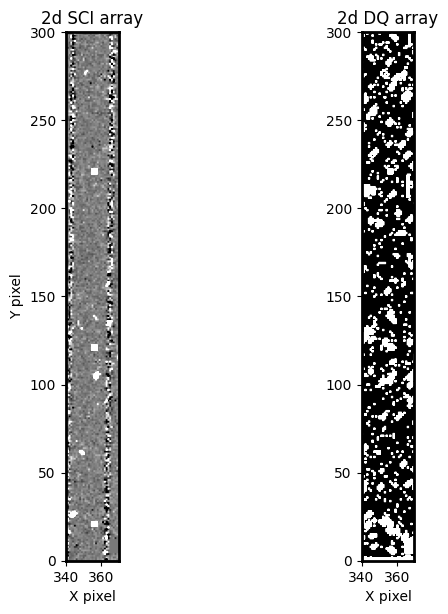

In [15]:
# Show the image and mask
hdu=fits.open('det_image_seq1_MIRIFUSHORT_12LONGexp1_od_test_a3001_crf.fits')
flux=hdu['SCI'].data
dq=hdu['DQ'].data

# Use a classic ZScale normalization
norm = ImageNormalize(flux, interval=ZScaleInterval(),stretch=LinearStretch())

rc('axes', linewidth=2)            
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(7,7),dpi=100)

# Plot the data to visually check outliers were inserted correctly
ax1.imshow(flux, cmap='gray',norm=norm,origin='lower')
ax1.set_title('2d SCI array')
ax1.set_xlabel('X pixel')
ax1.set_ylabel('Y pixel')
ax1.set_xlim(340,370)
ax1.set_ylim(0, 300)

ax2.imshow(dq, cmap='gray',vmin=0,vmax=1,origin='lower')
ax2.set_title('2d DQ array')
ax2.set_xlabel('X pixel')
ax2.set_xlim(340,370)
ax2.set_ylim(0, 300)

In [16]:
# Check DQ flags due to the the above plots being messy
print('flux:', flux[21,355], 'DQ Flag:', dq[21,355], 'DQ Name:', dqflags.dqflags_to_mnemonics(dq[21,355],mnemonic_map=datamodels.dqflags.pixel))

print('flux:',flux[121,355], 'DQ Flag:', dq[121,355], 'DQ Name:', dqflags.dqflags_to_mnemonics(dq[121,355],mnemonic_map=datamodels.dqflags.pixel))

print('flux:',flux[221,355], 'DQ Flag:', dq[221,355], 'DQ Name:', dqflags.dqflags_to_mnemonics(dq[221,355],mnemonic_map=datamodels.dqflags.pixel))

print('flux:',flux[321,355], 'DQ Flag:', dq[321,355], 'DQ Name:', dqflags.dqflags_to_mnemonics(dq[321,355],mnemonic_map=datamodels.dqflags.pixel))

print('flux:',flux[421,355], 'DQ Flag:', dq[421,355], 'DQ Name:', dqflags.dqflags_to_mnemonics(dq[421,355],mnemonic_map=datamodels.dqflags.pixel))

print('flux:',flux[521,355], 'DQ Flag:', dq[521,355], 'DQ Name:', dqflags.dqflags_to_mnemonics(dq[521,355],mnemonic_map=datamodels.dqflags.pixel))

print('flux:',flux[621,355], 'DQ Flag:', dq[621,355], 'DQ Name:', dqflags.dqflags_to_mnemonics(dq[621,355],mnemonic_map=datamodels.dqflags.pixel))

print('flux:',flux[721,355], 'DQ Flag:', dq[721,355], 'DQ Name:', dqflags.dqflags_to_mnemonics(dq[721,355],mnemonic_map=datamodels.dqflags.pixel))

print('flux:',flux[821,355], 'DQ Flag:', dq[821,355], 'DQ Name:', dqflags.dqflags_to_mnemonics(dq[821,355],mnemonic_map=datamodels.dqflags.pixel))

print('flux:',flux[921,355], 'DQ Flag:', dq[921,355], 'DQ Name:', dqflags.dqflags_to_mnemonics(dq[921,355],mnemonic_map=datamodels.dqflags.pixel))

flux: 3000.0 DQ Flag: 21 DQ Name: {'OUTLIER', 'DO_NOT_USE', 'JUMP_DET'}
flux: 6000.0 DQ Flag: 21 DQ Name: {'OUTLIER', 'DO_NOT_USE', 'JUMP_DET'}
flux: 9000.0 DQ Flag: 17 DQ Name: {'OUTLIER', 'DO_NOT_USE'}
flux: 12000.0 DQ Flag: 17 DQ Name: {'OUTLIER', 'DO_NOT_USE'}
flux: 15000.0 DQ Flag: 17 DQ Name: {'OUTLIER', 'DO_NOT_USE'}
flux: 18000.0 DQ Flag: 17 DQ Name: {'OUTLIER', 'DO_NOT_USE'}
flux: 21000.0 DQ Flag: 17 DQ Name: {'OUTLIER', 'DO_NOT_USE'}
flux: 24000.0 DQ Flag: 17 DQ Name: {'OUTLIER', 'DO_NOT_USE'}
flux: 27000.0 DQ Flag: 21 DQ Name: {'OUTLIER', 'DO_NOT_USE', 'JUMP_DET'}
flux: 30000.0 DQ Flag: 17 DQ Name: {'OUTLIER', 'DO_NOT_USE'}


In [17]:
# Close files
hdu.close()

In [18]:
# Cube without outlier rejection
hdu1=fits.open('od_before_ch1-long_s3d.fits')
flux1=hdu1['SCI'].data

# Cube with outlier rejection
hdu2=fits.open('od_after_ch1-long_s3d.fits')
flux2=hdu2['SCI'].data

# Use a classic ZScale normalization
norm = ImageNormalize(flux1, interval=ZScaleInterval(),stretch=LinearStretch())

Text(0.5, 1.0, 'With Outlier Det., Input 3000')

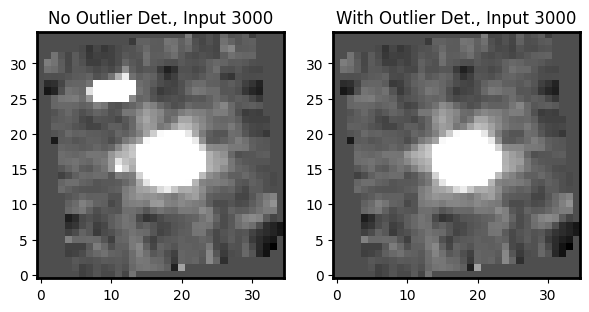

In [19]:
rc('axes', linewidth=2)            
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7,7),dpi=100)

# Plot data
ax1.imshow(flux1[1,:,:], cmap='gray',norm=norm,origin='lower')
ax1.set_title('No Outlier Det., Input 3000')

ax2.imshow(flux2[1,:,:], cmap='gray',norm=norm,origin='lower')
ax2.set_title('With Outlier Det., Input 3000')

Text(0.5, 1.0, 'With Outlier Det., Input 6000')

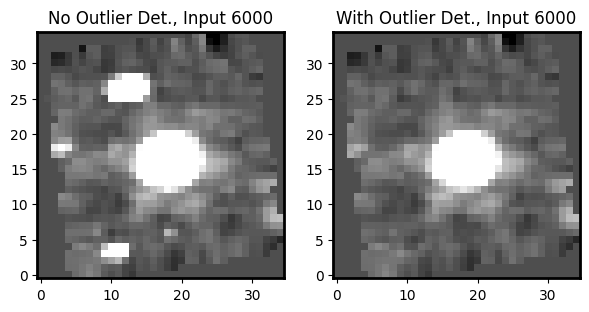

In [20]:
rc('axes', linewidth=2)            
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7,7),dpi=100)

# Plot data
ax1.imshow(flux1[126,:,:], cmap='gray',norm=norm,origin='lower')
ax1.set_title('No Outlier Det., Input 6000')

ax2.imshow(flux2[126,:,:], cmap='gray',norm=norm,origin='lower')
ax2.set_title('With Outlier Det., Input 6000')

Text(0.5, 1.0, 'With Outlier Det., Input 9000')

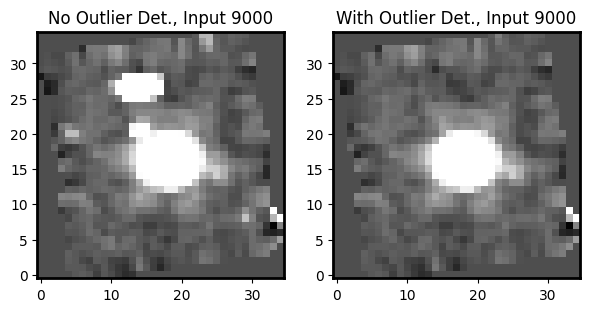

In [21]:
rc('axes', linewidth=2)            
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7,7),dpi=100)

# Plot data
ax1.imshow(flux1[249,:,:], cmap='gray',norm=norm,origin='lower')
ax1.set_title('No Outlier Det., Input 9000')

ax2.imshow(flux2[249,:,:], cmap='gray',norm=norm,origin='lower')
ax2.set_title('With Outlier Det., Input 9000')

Text(0.5, 1.0, 'With Outlier Det., Input 12000')

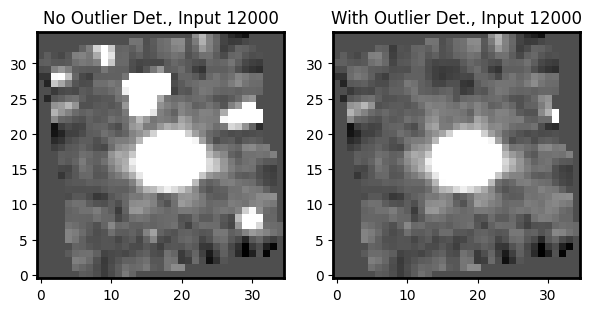

In [22]:
rc('axes', linewidth=2)            
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7,7),dpi=100)

# Plot data
ax1.imshow(flux1[369,:,:], cmap='gray',norm=norm,origin='lower')
ax1.set_title('No Outlier Det., Input 12000')

ax2.imshow(flux2[369,:,:], cmap='gray',norm=norm,origin='lower')
ax2.set_title('With Outlier Det., Input 12000')

Text(0.5, 1.0, 'With Outlier Det., Input 15000')

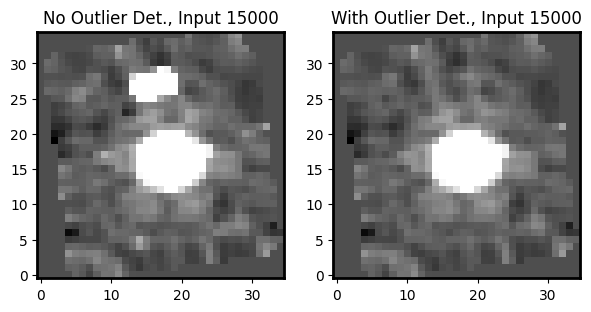

In [23]:
rc('axes', linewidth=2)            
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7,7),dpi=100)

# Plot data
ax1.imshow(flux1[486,:,:], cmap='gray',norm=norm,origin='lower')
ax1.set_title('No Outlier Det., Input 15000')

ax2.imshow(flux2[486,:,:], cmap='gray',norm=norm,origin='lower')
ax2.set_title('With Outlier Det., Input 15000')

Text(0.5, 1.0, 'With Outlier Det., Input 18000')

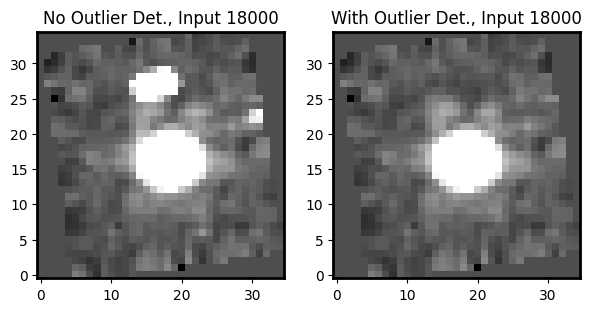

In [24]:
rc('axes', linewidth=2)            
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7,7),dpi=100)

# Plot data
ax1.imshow(flux1[600,:,:], cmap='gray',norm=norm,origin='lower')
ax1.set_title('No Outlier Det., Input 18000')

ax2.imshow(flux2[600,:,:], cmap='gray',norm=norm,origin='lower')
ax2.set_title('With Outlier Det., Input 18000')

Text(0.5, 1.0, 'With Outlier Det., Input 21000')

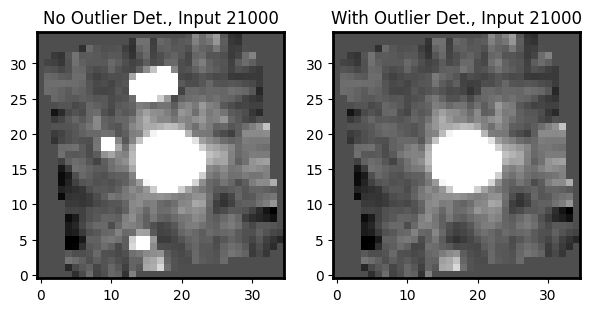

In [25]:
rc('axes', linewidth=2)            
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7,7),dpi=100)

# Plot data
ax1.imshow(flux1[712,:,:], cmap='gray',norm=norm,origin='lower')
ax1.set_title('No Outlier Det., Input 21000')

ax2.imshow(flux2[712,:,:], cmap='gray',norm=norm,origin='lower')
ax2.set_title('With Outlier Det., Input 21000')

Text(0.5, 1.0, 'With Outlier Det., Input 24000')

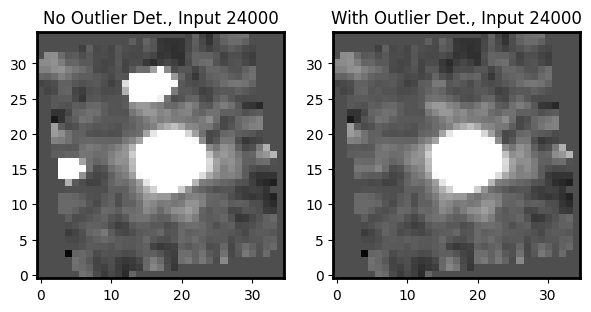

In [26]:
rc('axes', linewidth=2)            
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7,7),dpi=100)

# Plot data
ax1.imshow(flux1[821,:,:], cmap='gray',norm=norm,origin='lower')
ax1.set_title('No Outlier Det., Input 24000')

ax2.imshow(flux2[821,:,:], cmap='gray',norm=norm,origin='lower')
ax2.set_title('With Outlier Det., Input 24000')

Text(0.5, 1.0, 'With Outlier Det., Input 27000')

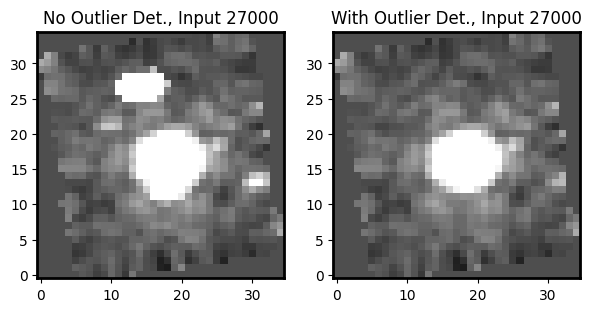

In [27]:
rc('axes', linewidth=2)            
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7,7),dpi=100)

# Plot data
ax1.imshow(flux1[927,:,:], cmap='gray',norm=norm,origin='lower')
ax1.set_title('No Outlier Det., Input 27000')

ax2.imshow(flux2[927,:,:], cmap='gray',norm=norm,origin='lower')
ax2.set_title('With Outlier Det., Input 27000')

Text(0.5, 1.0, 'With Outlier Det., Input 30000')

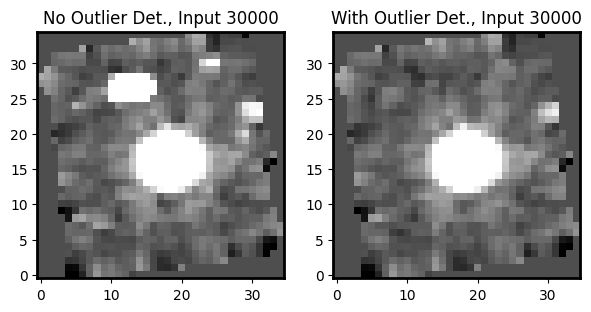

In [28]:
rc('axes', linewidth=2)            
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7,7),dpi=100)

# Plot data
ax1.imshow(flux1[1030,:,:], cmap='gray',norm=norm,origin='lower')
ax1.set_title('No Outlier Det., Input 30000')

ax2.imshow(flux2[1030,:,:], cmap='gray',norm=norm,origin='lower')
ax2.set_title('With Outlier Det., Input 30000')


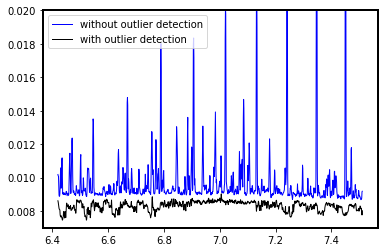

In [29]:
# Plot spectrum of point source before outlier detection
image1,header1=fits.getdata('od_before_ch1-long_s3d.fits',header=True)
num_x1=header1["NAXIS2"]
num_y1=header1["NAXIS1"]
num_chan1=header1["NAXIS3"]
start_wavelength1=header1["CRVAL3"]
step_wavelength1=header1["CDELT3"]
pix_size1=header1["PIXAR_SR"]

# Get wavelength
d1=[0.0]*num_chan1
d1[0]=start_wavelength1
for i in range(1,num_chan1):
    d1[i]=d1[i-1]+step_wavelength1

# Get flux
a1=[0.0]*num_chan1
for i in range(0,num_chan1):
    for m in range(10,30):
        for n in range(10,30):
            a1[i]=image1[i,m,n]+a1[i] 
for i in range(0,num_chan1):
    a1[i]=a1[i]*(10**6)*(pix_size1)

# Plot spectrum of point source before outlier detection
plt.plot(d1,a1,'-', color='blue', lw=1, label='without outlier detection')

# Plot spectrum of point source after outlier detection
image2,header2=fits.getdata('od_after_ch1-long_s3d.fits',header=True)
num_x2=header2["NAXIS2"]
num_y2=header2["NAXIS1"]
num_chan2=header2["NAXIS3"]
start_wavelength2=header2["CRVAL3"]
step_wavelength2=header2["CDELT3"]
pix_size2=header2["PIXAR_SR"]

#Get wavelength
d2=[0.0]*num_chan1
d2[0]=start_wavelength2
for i in range(1,num_chan2):
    d2[i]=d2[i-1]+step_wavelength2

#Get flux
a2=[0.0]*num_chan2
for i in range(0,num_chan2):
    for m in range(10,30):
        for n in range(10,30):
            a2[i]=image2[i,m,n]+a2[i] 
for i in range(0,num_chan2):
    a2[i]=a2[i]*(10**6)*(pix_size2)

#Plot spectrum
plt.plot(d2,a2,'-', color='black', lw=1, label='with outlier detection')

#Edit plot settings
plt.ylim(0.007, 0.020)
plt.legend()

In [30]:
# Pass/Fail criteria that determines flux of central source before and after outlier detection
before_flux=[0.0]*10
after_flux=[0.0]*10

sum_before1=0.0
sum_after1=0.0
sum_before2=0.0
sum_after2=0.0
sum_before3=0.0
sum_after3=0.0
sum_before4=0.0
sum_after4=0.0
sum_before5=0.0
sum_after5=0.0
sum_before6=0.0
sum_after6=0.0
sum_before7=0.0
sum_after7=0.0
sum_before8=0.0
sum_after8=0.0
sum_before9=0.0
sum_after9=0.0
sum_before10=0.0
sum_after10=0.0

for i in range(15,30):
    for j in range(15, 30):
        sum_before1=sum_before1+flux1[1,j,i]

for i in range(15,30):
    for j in range(15,30):
        sum_after1=sum_after1+flux2[1,j,i]

for i in range(15,30):
    for j in range(15, 30):
        sum_before2=sum_before2+flux1[126,j,i]

for i in range(15,30):
    for j in range(15,30):
        sum_after2=sum_after2+flux2[126,j,i]

for i in range(15,30):
    for j in range(15,30):
        sum_before3=sum_before3+flux1[249,j,i]

for i in range(15,30):
    for j in range(15,30):
        sum_after3=sum_after3+flux2[249,j,i]

for i in range(15,30):
    for j in range(15,30):
        sum_before4=sum_before4+flux1[369,j,i]

for i in range(15,30):
    for j in range(15,30):
        sum_after4=sum_after4+flux2[369,j,i]
        
for i in range(15,30):
    for j in range(15,30):
        sum_before5=sum_before5+flux1[486,j,i]

for i in range(15,30):
    for j in range(15,30):
        sum_after5=sum_after5+flux2[486,j,i]
        
for i in range(15,30):
    for j in range(15,30):
        sum_before6=sum_before6+flux1[600,j,i]

for i in range(15,30):
    for j in range(15,30):
        sum_after6=sum_after6+flux2[600,j,i]
        
for i in range(15,30):
    for j in range(15,30):
        sum_before7=sum_before7+flux1[712,j,i]

for i in range(15,30):
    for j in range(15,30):
        sum_after7=sum_after7+flux2[712,j,i]
        
for i in range(15,30):
    for j in range(15,30):
        sum_before8=sum_before8+flux1[821,j,i]

for i in range(15,30):
    for j in range(15,30):
        sum_after8=sum_after8+flux2[821,j,i]
        
for i in range(15,30):
    for j in range(15,30):
        sum_before9=sum_before9+flux1[927,j,i]

for i in range(15,30):
    for j in range(15,30):
        sum_after9=sum_after9+flux2[927,j,i]
        
for i in range(15,30):
    for j in range(15,30):
        sum_before10=sum_before10+flux1[1030,j,i]

for i in range(15,30):
    for j in range(15,30):
        sum_after10=sum_after10+flux2[1030,j,i]

for a in range(0,10):
    before_flux[0]=sum_before1
    before_flux[1]=sum_before2
    before_flux[2]=sum_before3
    before_flux[3]=sum_before4
    before_flux[4]=sum_before5
    before_flux[5]=sum_before6
    before_flux[6]=sum_before7
    before_flux[7]=sum_before8
    before_flux[8]=sum_before9
    before_flux[9]=sum_before10

for a in range(0,10):
    after_flux[0]=sum_after1
    after_flux[1]=sum_after2
    after_flux[2]=sum_after3
    after_flux[3]=sum_after4
    after_flux[4]=sum_after5
    after_flux[5]=sum_after6
    after_flux[6]=sum_after7
    after_flux[7]=sum_after8
    after_flux[8]=sum_after9
    after_flux[9]=sum_after10

print(before_flux[0],',',after_flux[0],',',100*(before_flux[0]-after_flux[0])/(before_flux[0]))
print(before_flux[1],',',after_flux[1],',',100*(before_flux[1]-after_flux[1])/(before_flux[1]))
print(before_flux[2],',',after_flux[2],',',100*(before_flux[2]-after_flux[2])/(before_flux[2]))
print(before_flux[3],',',after_flux[3],',',100*(before_flux[3]-after_flux[3])/(before_flux[3]))
print(before_flux[4],',',after_flux[4],',',100*(before_flux[4]-after_flux[4])/(before_flux[4]))
print(before_flux[5],',',after_flux[5],',',100*(before_flux[5]-after_flux[5])/(before_flux[5]))
print(before_flux[6],',',after_flux[6],',',100*(before_flux[6]-after_flux[6])/(before_flux[6]))
print(before_flux[7],',',after_flux[7],',',100*(before_flux[7]-after_flux[7])/(before_flux[7]))
print(before_flux[8],',',after_flux[8],',',100*(before_flux[8]-after_flux[8])/(before_flux[8]))
print(before_flux[9],',',after_flux[9],',',100*(before_flux[9]-after_flux[9])/(before_flux[9]))

19295.366788432002 , 18830.334127411246 , 2.410074222064299
21162.93411268294 , 18838.809448614717 , 10.98205311084617
25009.81030934304 , 18168.340026177466 , 27.355146634637897
34449.41758560389 , 18415.80912554264 , 46.54246597992285
39500.415709748864 , 18846.196913184598 , 52.28861120939221
45213.26934795681 , 18758.62971514091 , 58.51078679850297
47776.69115463551 , 17734.07387869712 , 62.88132675136821
45542.94931918103 , 16969.221405597404 , 62.740178975517985
38429.02047620341 , 17970.676567506045 , 53.23670407203297
24227.86565429624 , 16722.600878432393 , 30.977820675396416


In [31]:
# Determine if the notebook passes or fails
count=0
for i in range(0,10):
    if 100*(before_flux[i]-after_flux[i])/(before_flux[i]) > 35:
        count=count+1

if count>1:
    print('This notebook does not pass.')
else:
    print('This notebook passes.')

This notebook does not pass.


In [32]:
# Close files
hdu1.close()
hdu2.close()